# Advanced Excitation Optimization Demo

This notebook demonstrates the improved excitation wavelength optimization algorithm that addresses the issues with the original approach.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from multiplex_sim import (
    OptimizationConfig, 
    AdvancedExcitationOptimizer,
    find_optimal_excitation_advanced,
    find_optimal_excitation,  # Original algorithm for comparison
    list_fluorophores
)

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load Available Fluorophores

In [31]:
# List available fluorophores
available_fluors = list_fluorophores('../data/spectra_npz')
print(f"Available fluorophores: {available_fluors}")

# Select a challenging set for optimization
test_fluorophores = ['JF479', 'JF552', 'JF608', 'JFX673', 'JF722']
print(f"\nSelected test set: {test_fluorophores}")

Available fluorophores: ['AF488', 'AF514', 'AF532', 'AF546', 'AF555', 'AF561', 'AF594', 'AF610', 'AF633', 'AF647', 'JF479', 'JF525', 'JF552', 'JF608', 'JF722', 'JFX650', 'JFX673', 'NADH - ', 'NADH']

Selected test set: ['JF479', 'JF552', 'JF608', 'JFX673', 'JF722']


## 2. Compare Original vs Advanced Optimization

In [32]:
print("=" * 80)
print("COMPARISON: Original vs Advanced Optimization")
print("=" * 80)

# Run original optimization
print("\n1. ORIGINAL OPTIMIZATION:")
print("-" * 40)
try:
    original_result = find_optimal_excitation(
        test_fluorophores,
        '../data/spectra_npz'
    )
    print("Original optimal wavelengths:")
    for name, wl in original_result.items():
        print(f"  {name}: {wl} nm")
except Exception as e:
    print(f"Original optimization failed: {e}")
    original_result = None

COMPARISON: Original vs Advanced Optimization

1. ORIGINAL OPTIMIZATION:
----------------------------------------
Optimal excitation wavelengths found:
JF479 @ 454.8 nm → self: 0.591, crosstalk: 0.762, net: 0.171
JF552 @ 552.6 nm → self: 0.007, crosstalk: 0.070, net: 0.063
JF608 @ 581.7 nm → self: 0.053, crosstalk: 0.039, net: -0.015
JFX673 @ 668.4 nm → self: 0.005, crosstalk: 0.086, net: 0.081
JF722 @ 736.9 nm → self: 0.022, crosstalk: 0.069, net: 0.047
Original optimal wavelengths:
  JF479: 455 nm
  JF552: 553 nm
  JF608: 582 nm
  JFX673: 668 nm
  JF722: 737 nm


In [33]:
# Run advanced optimization
print("\n2. ADVANCED OPTIMIZATION:")
print("-" * 40)

# Configure advanced optimization
config = OptimizationConfig(
    search_range=50.0,
    min_wavelength_separation=15.0,
    signal_strength_weight=2.0,
    crosstalk_weight=3.0,
    separation_penalty_weight=5.0,
    n_multistart=1,
    population_size=100,
    background_weight=1.0,
    max_iterations=300
)

try:
    advanced_result = find_optimal_excitation_advanced(
        test_fluorophores,
        '../data/spectra_npz',
        config=config
    )
except Exception as e:
    print(f"Advanced optimization failed: {e}")
    advanced_result = None


2. ADVANCED OPTIMIZATION:
----------------------------------------
ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF552, JF608, JFX673, JF722
Search range: ±50.0 nm around peaks
Min separation: 15.0 nm
Running multi-start optimization with 1 starts...
  Start 1/1... Success (cost: -7.9211)
Optimization completed in 19.29 seconds

Optimization Results:
Success rate: 1/1
Best cost: -7.9211
Optimization time: 19.29s

Optimal Excitation Wavelengths:
  JF479: 477 nm
  JF552: 549 nm
  JF608: 605 nm
  JFX673: 673 nm
  JF722: 727 nm

Validation Metrics:
  Signal strength: 4.948
  Crosstalk penalty: 0.658
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 53.6 nm
  Max crosstalk: 0.207
  Mean crosstalk: 0.026


## 3. Detailed Analysis with Advanced Optimizer

In [34]:
# Create advanced optimizer for detailed analysis
optimizer = AdvancedExcitationOptimizer(
    test_fluorophores,
    '../data/spectra_npz',
    config
)

# Run full optimization with detailed results
detailed_results = optimizer.find_optimal_excitation()

ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF479, JF552, JF608, JFX673, JF722
Search range: ±50.0 nm around peaks
Min separation: 15.0 nm
Running multi-start optimization with 1 starts...
  Start 1/1... Success (cost: -7.9211)
Optimization completed in 19.30 seconds

Optimization Results:
Success rate: 1/1
Best cost: -7.9211
Optimization time: 19.30s

Optimal Excitation Wavelengths:
  JF479: 477 nm
  JF552: 549 nm
  JF608: 605 nm
  JFX673: 673 nm
  JF722: 727 nm

Validation Metrics:
  Signal strength: 4.948
  Crosstalk penalty: 0.658
  Detection separability: 0.000
  Background penalty: 0.000
  Min wavelength separation: 53.6 nm
  Max crosstalk: 0.207
  Mean crosstalk: 0.026


## 4. Visualization of Results

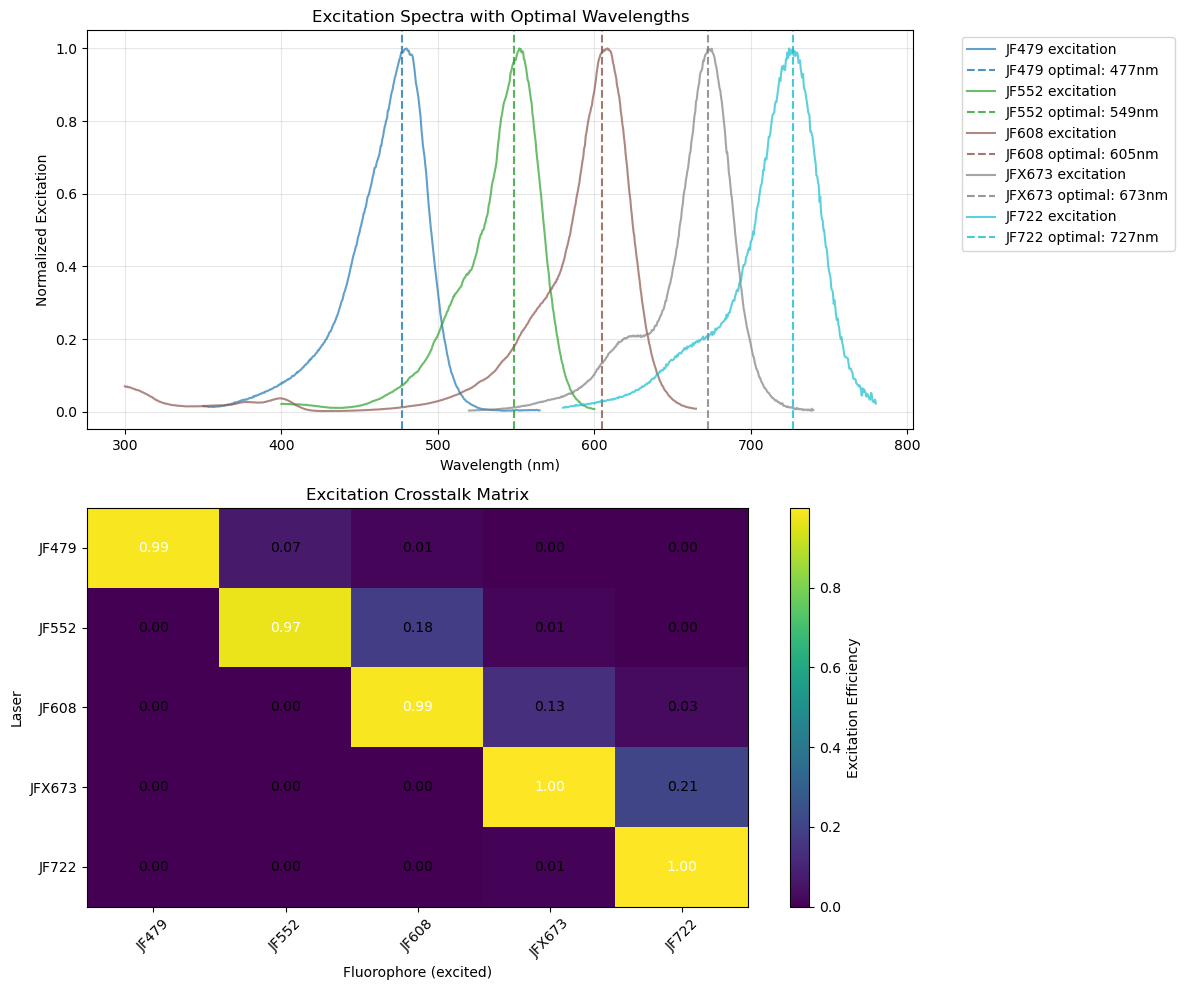

In [35]:
# Plot excitation spectra with optimal wavelengths
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Load and plot excitation spectra
colors = plt.cm.tab10(np.linspace(0, 1, len(test_fluorophores)))

for i, name in enumerate(test_fluorophores):
    if name in optimizer.excitation_spectra:
        wl, ex = optimizer.excitation_spectra[name]
        ax1.plot(wl, ex, label=f'{name} excitation', color=colors[i], alpha=0.7)
        
        # Mark optimal wavelength
        if advanced_result and name in advanced_result:
            opt_wl = advanced_result[name]
            ax1.axvline(opt_wl, color=colors[i], linestyle='--', alpha=0.8, 
                       label=f'{name} optimal: {opt_wl}nm')

ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Normalized Excitation')
ax1.set_title('Excitation Spectra with Optimal Wavelengths')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot crosstalk matrix
if 'validation' in detailed_results:
    crosstalk_matrix = detailed_results['validation']['crosstalk_matrix']
    im = ax2.imshow(crosstalk_matrix, cmap='viridis', aspect='auto')
    ax2.set_xticks(range(len(test_fluorophores)))
    ax2.set_yticks(range(len(test_fluorophores)))
    ax2.set_xticklabels(test_fluorophores, rotation=45)
    ax2.set_yticklabels(test_fluorophores)
    ax2.set_xlabel('Fluorophore (excited)')
    ax2.set_ylabel('Laser')
    ax2.set_title('Excitation Crosstalk Matrix')
    
    # Add text annotations
    for i in range(len(test_fluorophores)):
        for j in range(len(test_fluorophores)):
            text = ax2.text(j, i, f'{crosstalk_matrix[i, j]:.2f}',
                           ha="center", va="center", color="white" if crosstalk_matrix[i, j] > 0.5 else "black")
    
    plt.colorbar(im, ax=ax2, label='Excitation Efficiency')

plt.tight_layout()
plt.show()

## 5. Cost Function Analysis

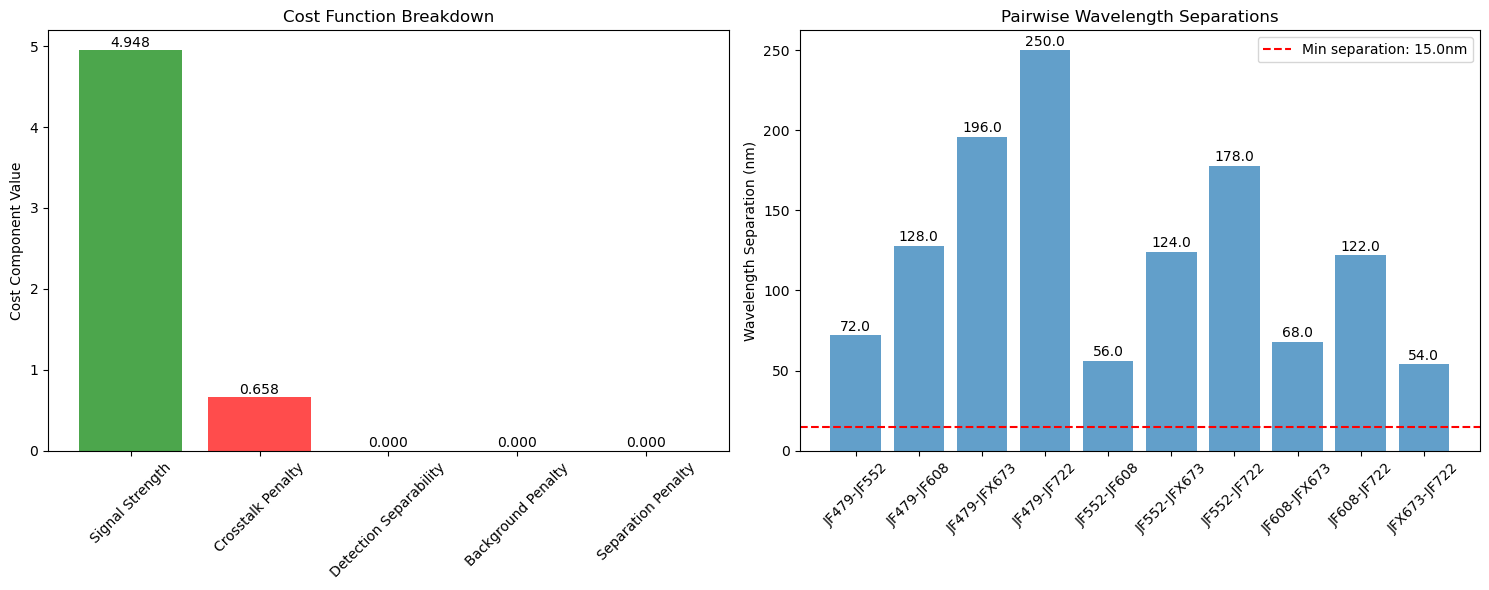

In [36]:
# Analyze cost function components
if 'validation' in detailed_results:
    val = detailed_results['validation']
    
    # Create cost breakdown plot
    components = [
        ('Signal Strength', val['signal_strength'], 'green'),
        ('Crosstalk Penalty', val['crosstalk_penalty'], 'red'),
        ('Detection Separability', val['detection_separability'], 'blue'),
        ('Background Penalty', val['background_penalty'], 'orange'),
        ('Separation Penalty', val['separation_penalty'], 'purple')
    ]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of cost components
    names, values, colors = zip(*components)
    bars = ax1.bar(names, values, color=colors, alpha=0.7)
    ax1.set_ylabel('Cost Component Value')
    ax1.set_title('Cost Function Breakdown')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom')
    
    # Wavelength separation analysis
    optimal_wls = [advanced_result[name] for name in test_fluorophores]
    separations = []
    pairs = []
    
    for i in range(len(optimal_wls)):
        for j in range(i+1, len(optimal_wls)):
            sep = abs(optimal_wls[i] - optimal_wls[j])
            separations.append(sep)
            pairs.append(f'{test_fluorophores[i]}-{test_fluorophores[j]}')
    
    bars2 = ax2.bar(range(len(separations)), separations, alpha=0.7)
    ax2.axhline(y=config.min_wavelength_separation, color='red', linestyle='--', 
               label=f'Min separation: {config.min_wavelength_separation}nm')
    ax2.set_xticks(range(len(pairs)))
    ax2.set_xticklabels(pairs, rotation=45)
    ax2.set_ylabel('Wavelength Separation (nm)')
    ax2.set_title('Pairwise Wavelength Separations')
    ax2.legend()
    
    # Add value labels
    for i, (bar, sep) in enumerate(zip(bars2, separations)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{sep:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 6. Optimization Convergence Analysis

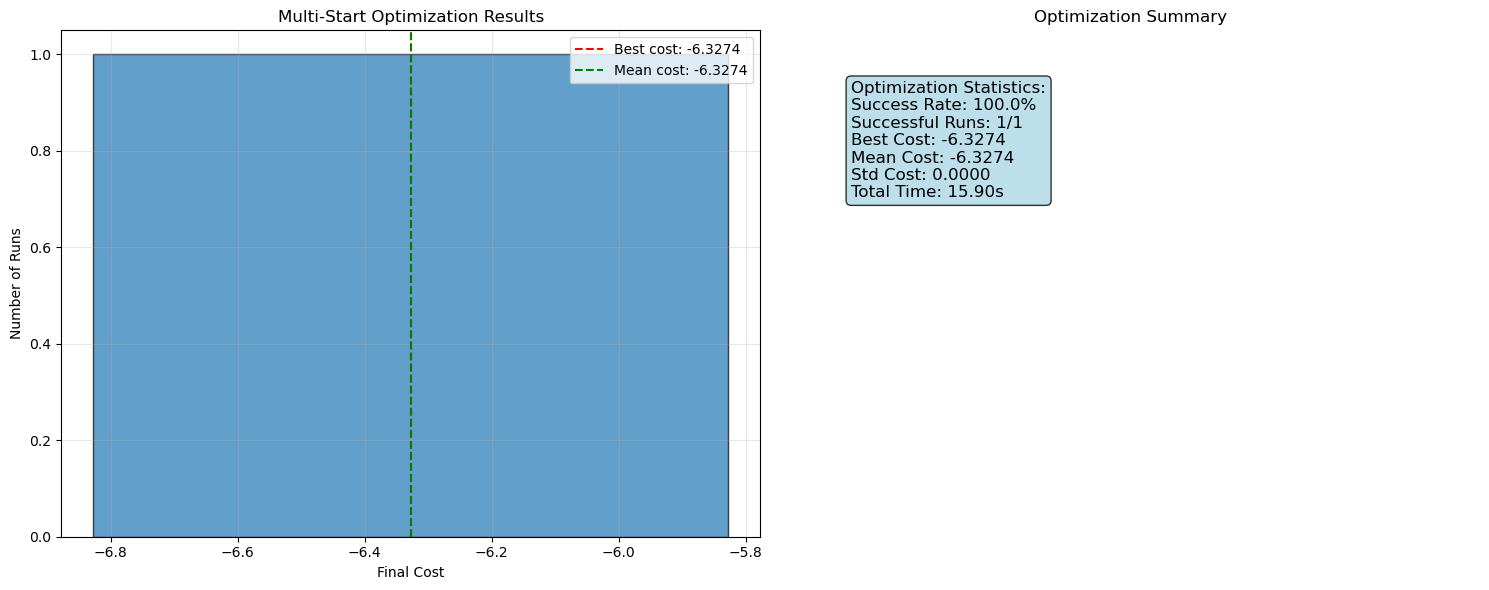

In [24]:
# Analyze multi-start optimization results
if 'optimization_result' in detailed_results:
    opt_result = detailed_results['optimization_result']
    all_results = opt_result['all_results']
    
    # Extract costs from all runs
    successful_costs = [r['cost'] for r in all_results if r['success']]
    failed_runs = len(all_results) - len(successful_costs)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram of final costs
    ax1.hist(successful_costs, bins=min(10, len(successful_costs)), alpha=0.7, edgecolor='black')
    ax1.axvline(opt_result['best_cost'], color='red', linestyle='--', 
               label=f'Best cost: {opt_result["best_cost"]:.4f}')
    ax1.axvline(opt_result['cost_mean'], color='green', linestyle='--', 
               label=f'Mean cost: {opt_result["cost_mean"]:.4f}')
    ax1.set_xlabel('Final Cost')
    ax1.set_ylabel('Number of Runs')
    ax1.set_title('Multi-Start Optimization Results')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Success rate and statistics
    success_rate = len(successful_costs) / len(all_results) * 100
    
    stats_text = f"""Optimization Statistics:
Success Rate: {success_rate:.1f}%
Successful Runs: {len(successful_costs)}/{len(all_results)}
Best Cost: {opt_result['best_cost']:.4f}
Mean Cost: {opt_result['cost_mean']:.4f}
Std Cost: {opt_result['cost_std']:.4f}
Total Time: {opt_result['optimization_time']:.2f}s"""
    
    ax2.text(0.1, 0.9, stats_text, transform=ax2.transAxes, fontsize=12,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    ax2.set_title('Optimization Summary')
    
    plt.tight_layout()
    plt.show()

## 7. Comparison Summary

In [25]:
print("=" * 80)
print("OPTIMIZATION COMPARISON SUMMARY")
print("=" * 80)

if original_result and advanced_result:
    print("\nWavelength Comparison:")
    print(f"{'Fluorophore':<12} {'Original':<10} {'Advanced':<10} {'Difference':<12}")
    print("-" * 50)
    
    for name in test_fluorophores:
        orig_wl = original_result.get(name, 'N/A')
        adv_wl = advanced_result.get(name, 'N/A')
        
        if orig_wl != 'N/A' and adv_wl != 'N/A':
            diff = abs(orig_wl - adv_wl)
            print(f"{name:<12} {orig_wl:<10} {adv_wl:<10} {diff:<12.1f}")
        else:
            print(f"{name:<12} {orig_wl:<10} {adv_wl:<10} {'N/A':<12}")

if 'validation' in detailed_results:
    val = detailed_results['validation']
    print(f"\nAdvanced Algorithm Performance:")
    print(f"  Signal Strength: {val['signal_strength']:.3f}")
    print(f"  Crosstalk Penalty: {val['crosstalk_penalty']:.3f}")
    print(f"  Min Separation: {val['min_separation']:.1f} nm")
    print(f"  Max Crosstalk: {val['max_crosstalk']:.3f}")
    print(f"  Mean Crosstalk: {val['mean_crosstalk']:.3f}")

print("\nKey Improvements in Advanced Algorithm:")
print("  ✓ Multi-objective cost function")
print("  ✓ Wavelength separation constraints")
print("  ✓ Multi-start optimization for robustness")
print("  ✓ Detection channel awareness")
print("  ✓ Background interference modeling")
print("  ✓ Comprehensive validation metrics")

OPTIMIZATION COMPARISON SUMMARY

Wavelength Comparison:
Fluorophore  Original   Advanced   Difference  
--------------------------------------------------
JF525        533        520        13.0        
JF552        570        554        16.0        
JF608        636        605        31.0        
JFX673       679        673        6.0         
JF722        729        727        2.0         

Advanced Algorithm Performance:
  Signal Strength: 4.911
  Crosstalk Penalty: 1.165
  Min Separation: 34.2 nm
  Max Crosstalk: 0.382
  Mean Crosstalk: 0.047

Key Improvements in Advanced Algorithm:
  ✓ Multi-objective cost function
  ✓ Wavelength separation constraints
  ✓ Multi-start optimization for robustness
  ✓ Detection channel awareness
  ✓ Background interference modeling
  ✓ Comprehensive validation metrics


## 8. Test with Detection Channel Configuration

In [ ]:
# Test optimization with specific detection channel configuration
print("\nTesting with Detection Channel Configuration:")
print("-" * 50)

# Define detection channels
detection_centers = [540, 580, 620, 680, 720]
detection_bandwidths = [25, 25, 25, 30, 30]


detection_bandwidths = np.array([34.21, 22.63, 32.11, 36.32, 36.32])
detection_centers = np.array([547.62, 576.38, 635.90, 684.48, 742.00])
# Configure optimization with detection awareness
detection_config = OptimizationConfig(
    search_range=40.0,
    min_wavelength_separation=12.0,
    detection_centers=detection_centers,
    detection_bandwidths=detection_bandwidths,
    detection_separability_weight=2.0,
    n_multistart=5,
    max_iterations=200
)

try:
    detection_aware_result = find_optimal_excitation_advanced(
        test_fluorophores,
        '../data/spectra_npz',
        detection_centers=detection_centers,
        detection_bandwidths=detection_bandwidths,
        config=detection_config
    )
    
    print("Detection-aware optimal wavelengths:")
    for name, wl in detection_aware_resultb.items():
        print(f"  {name}: {wl} nm")
        
except Exception as e:
    print(f"Detection-aware optimization failed: {e}")


Testing with Detection Channel Configuration:
--------------------------------------------------
ADVANCED EXCITATION WAVELENGTH OPTIMIZATION
Fluorophores: JF525, JF552, JF608, JFX673, JF722
Search range: ±40.0 nm around peaks
Min separation: 12.0 nm
Running multi-start optimization with 5 starts...
  Start 1/5... Success (cost: -2.7887)
  Start 2/5... Success (cost: -2.7887)
  Start 3/5... Success (cost: -2.7887)
  Start 4/5... Success (cost: -2.7887)
  Start 5/5... Success (cost: -2.7887)
Optimization completed in 23.70 seconds

Optimization Results:
Success rate: 5/5
Best cost: -2.7887
Optimization time: 23.70s

Optimal Excitation Wavelengths:
  JF525: 519 nm
  JF552: 554 nm
  JF608: 603 nm
  JFX673: 673 nm
  JF722: 727 nm

Validation Metrics:
  Signal strength: 4.874
  Crosstalk penalty: 1.145
  Detection separability: 0.102
  Background penalty: 0.000
  Min wavelength separation: 34.5 nm
  Max crosstalk: 0.377
  Mean crosstalk: 0.046
Detection-aware optimal wavelengths:
  JF525: 5

In [30]:
list(detection_aware_result.values())

[np.int64(519), np.int64(554), np.int64(603), np.int64(673), np.int64(727)]

## Conclusion

The advanced excitation optimization algorithm provides significant improvements over the original approach:

1. **Multi-objective optimization**: Balances signal strength, crosstalk minimization, detection separability, and background interference
2. **Robust search**: Multi-start optimization ensures finding global optima
3. **Physical constraints**: Enforces minimum wavelength separation and practical bounds
4. **Detection awareness**: Considers actual detection filter configurations
5. **Comprehensive validation**: Provides detailed metrics for solution quality

This should resolve the issues with poor excitation wavelength selection and provide much better multiplexing performance.